<a href="https://colab.research.google.com/github/K532001/TradeTact-Advanced-Predictive-Modeling-for-Nasdaq-Movements/blob/main/cse519_hw3_GARG_KUNAL_115362488.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [ ]:
## First mount your drive before running analysis code
from google.colab import drive
drive.mount('/content/drive')

## Create a folder for the this HW and change to that dir
%cd drive/MyDrive/cse519


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/cse519'
/content/drive/MyDrive/cse519


In [ ]:
## packages
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Matplotlib
!pip install -q seaborn


In [ ]:
## Upload the file by clicking on the browse
from google.colab import files
files.upload()

## Create a new API token under "Account" in the kaggle webpage and download the json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kunalgargmm","key":"f00f036117ac3553bd566f12748e9ed0"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c optiver-trading-at-the-close
!unzip optiver-trading-at-the-close.zip
!ls

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 95% 190M/201M [00:01<00:00, 132MB/s]
100% 201M/201M [00:01<00:00, 130MB/s]
Archive:  optiver-trading-at-the-close.zip
  inflating: example_test_files/revealed_targets.csv  
  inflating: example_test_files/sample_submission.csv  
  inflating: example_test_files/test.csv  
  inflating: optiver2023/__init__.py  
  inflating: optiver2023/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: public_timeseries_testing_util.py  
  inflating: train.csv               
example_test_files  optiver-trading-at-the-close.zip
kaggle.json	    public_timeseries_testing_util.py
optiver2023	    train.csv


#### Q1: Anomalies and Cleaning, 15 pts


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": np.int,
  "date_id":np.int,
  "seconds_in_bucket":np.int,
  "imbalance_size":np.float64,
  "imbalance_buy_sell_flag":np.int,
  "reference_price":np.float64,
  "matched_size":np.float64,
  "far_price":np.float64,
  "near_price":np.float64,
  "bid_price":np.float64,
  "bid_size":np.float64,
  "ask_price":np.float64,
  "ask_size":np.float64,
  "wap":np.float64,
  "target":np.float64,
  "time_id":np.int,
  "row_id": "string",
}
csv = pd.read_csv("train.csv")


<ipython-input-100-ac28b01514d1>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "stock_id": np.int,
<ipython-input-100-ac28b01514d1>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details

In [ ]:
csv = csv.astype(dtypes)
csv.head()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


# Describing the data to see the missing values


In [ ]:

data_info = csv.info()
data_head = csv.head()
missing_values = csv.isnull().sum()
duplicate_rows = csv.duplicated().sum()

(data_info, data_head, missing_values, duplicate_rows)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   string 
dtypes: float64(11), int64(5), string(1)
memory usage: 679.4 MB


(None,
    stock_id  date_id  seconds_in_bucket  imbalance_size  \
 0         0        0                  0      3180602.69   
 1         1        0                  0       166603.91   
 2         2        0                  0       302879.87   
 3         3        0                  0     11917682.27   
 4         4        0                  0       447549.96   
 
    imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
 0                        1         0.999812   13380276.64        NaN   
 1                       -1         0.999896    1642214.25        NaN   
 2                       -1         0.999561    1819368.03        NaN   
 3                       -1         1.000171   18389745.62        NaN   
 4                       -1         0.999532   17860614.95        NaN   
 
    near_price  bid_price  bid_size  ask_price   ask_size  wap    target  \
 0         NaN   0.999812  60651.50   1.000026    8493.03  1.0 -3.029704   
 1         NaN   0.999896   3233.04   1

# Cleaning the data

- I have used pchip interpolation to fill in the missing values for imbalance size, reference size, matched size, bid price, ask price wap , near price, far price. I have done so because it is time series data and hence droppping these values may cause conflict later.
- there were 80 rows with nan target values, I have decided to drop those rows.
- for near and far price, they arent reported for the first 5 minutes, hence I have filled those nan values with 0 (this is for the model), for seconds in bucket > 300, i have similarly used pchip interpolation.
- for correlation and consensus calculation, I will fill the near and far values for the first 5 mins back to nan so they do not affect the correlation and median for consensus.


In [ ]:
cleaned_csv = csv.copy()
cleaned_csv.loc[(cleaned_csv['seconds_in_bucket'] < 300) & (cleaned_csv['near_price'].isnull()), 'near_price'] = 0
cleaned_csv.loc[(cleaned_csv['seconds_in_bucket'] < 300) & (cleaned_csv['far_price'].isnull()), 'far_price'] = 0
cleaned_csv = cleaned_csv.dropna(subset=['target'])

features_with_missing_values = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap', 'near_price', 'far_price']

for feature in features_with_missing_values:
    cleaned_csv[feature] = cleaned_csv[feature].interpolate(method='pchip')



cleaned_csv.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.0,0.0,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.0,0.0,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.0,0.0,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.0,0.0,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


# Describing the data after it has been cleaned
I have made a copy of the orginal df and am doing the cleaning in the cleaned_csv.

In [ ]:
data_info = cleaned_csv.info()
data_head = cleaned_csv.head()
missing_values = cleaned_csv.isnull().sum()
duplicate_rows = cleaned_csv.duplicated().sum()

(data_info, data_head, missing_values, duplicate_rows)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5237892 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   string 
dtypes: float64(11), int64(5), string(1)
memory usage: 719.3 MB


(None,
    stock_id  date_id  seconds_in_bucket  imbalance_size  \
 0         0        0                  0      3180602.69   
 1         1        0                  0       166603.91   
 2         2        0                  0       302879.87   
 3         3        0                  0     11917682.27   
 4         4        0                  0       447549.96   
 
    imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
 0                        1         0.999812   13380276.64        0.0   
 1                       -1         0.999896    1642214.25        0.0   
 2                       -1         0.999561    1819368.03        0.0   
 3                       -1         1.000171   18389745.62        0.0   
 4                       -1         0.999532   17860614.95        0.0   
 
    near_price  bid_price  bid_size  ask_price   ask_size  wap    target  \
 0         0.0   0.999812  60651.50   1.000026    8493.03  1.0 -3.029704   
 1         0.0   0.999896   3233.04   1

### Q2: Pairwise Corralation Table and Explaition. 10 pts

- Reference Price vs. WAP, Bid Price, and Ask Price:

Correlation: Approximately 0.98 to 0.99
Interpretation: The reference price of a stock is highly correlated with its WAP, bid price, and ask price. This is expected, as the reference price is  derived from these values.

- Near Price vs. Bid Price and Ask Price:

Correlation: Approximately 0.46

Interpretation: This shows that the near price often tends to be around the bid and ask prices. since the near price has both, auction orders and continous orders in taken in account for.

- Bid Price vs. Ask Price:

Correlation: Approximately 0.97

Interpretation: Bid price and ask price are very highly correlated as this shows the market conditions and, how people are ready to adjust their buying and selling prices based on the available prices in the market.

- Bid Size vs. Ask Size:

Correlation: Approximately 0.28

Interpretation: There is a slightly positive correlation between bid size and ask size. This suggests that when there are more shares available to buy, there might also be more shares available to sell.

- Imbalance Size vs. Matched Size:

Correlation: Approximately 0.51

Interpretation: There's a moderate positive correlation between imbalance size and matched size. This indicates that there is a higher volume of trades being matched on days with larger order imbalances.

- Date ID vs. Time ID:

Correlation: Approximately 1

Interpretation: The date and time IDs are  perfectly correlated. This shows that data is chronological in order.


<ipython-input-105-d3d42a3f4a85>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_table = corr_csv.corr(method='pearson')


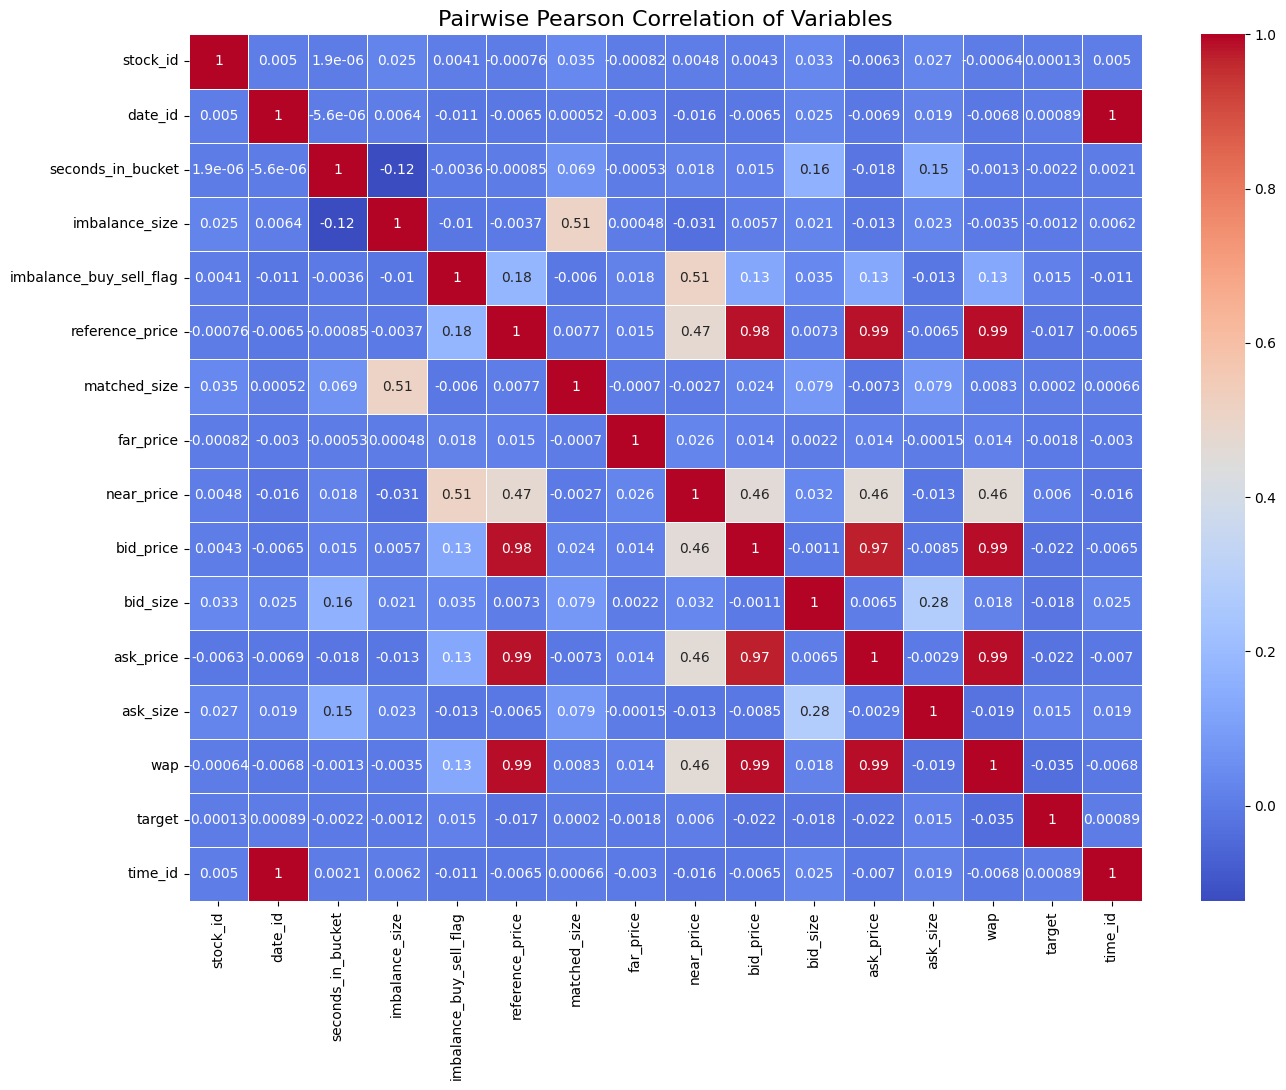

In [ ]:
corr_csv = cleaned_csv.copy()
# i have put near_price and far_price as nan again so that, they do not give erronous correlation due to 0 values that i have used previously in cleaned data.
# the cleaned_csv is for the model to train upon.
corr_csv.loc[corr_csv['seconds_in_bucket'] < 300, ['near_price', 'far_price']] = np.nan
correlation_table = corr_csv.corr(method='pearson')
plt.figure(figsize=(14, 11))

# Plotting the correlation heatmap
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', linewidths=0.5)


plt.title("Pairwise Pearson Correlation of Variables", fontsize=16)
plt.tight_layout()
plt.show()

#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts


- I have used mean as the metric to calculate the consensus record for the stocks. I have also used minmaxscaler to normalize the matche_size, ask_size, bid_size. I have done so because I will be using euclidean distance and, it is affecting by the size of the variables.

In [ ]:

from sklearn.preprocessing import MinMaxScaler



scaler = MinMaxScaler()

# Normalize the columns using minmaxscaler
for column in ['matched_size', 'ask_size', 'bid_size']:
    cleaned_csv[column] = scaler.fit_transform(cleaned_csv[[column]])
consensus_record = cleaned_csv.copy()
consensus_record.loc[consensus_record['seconds_in_bucket'] < 300, ['near_price', 'far_price']] = np.nan
consensus_record = cleaned_csv.groupby(['stock_id', 'date_id']).mean().reset_index()
grouped = consensus_record.groupby(['stock_id', 'date_id'])
consensus_record['price_spread'] = consensus_record['near_price'] - consensus_record['far_price']


consensus_record['relative_wap'] = consensus_record['wap'] - (consensus_record['near_price'] + consensus_record['far_price']) / 2


consensus_record['near_to_wap_ratio'] = consensus_record['near_price'] / consensus_record['wap']
consensus_record['far_to_wap_ratio'] = consensus_record['far_price'] / consensus_record['wap']
consensus_record['volatility'] = grouped['wap'].transform('std')
# Fill NaN values in 'volatility' with zeros
consensus_record['volatility'] = grouped['volatility'].fillna(0)



# Calculate Momentum as the difference between the last and first WAP of the day
consensus_record['momentum'] = grouped['wap'].transform('last') - grouped['wap'].transform('first')

# Calculate Liquidity as the average of bid_size and ask_size
consensus_record['liquidity'] = (consensus_record['bid_size'] + consensus_record['ask_size']) / 2
consensus_record.head()

<ipython-input-106-becf0046f970>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  consensus_record = cleaned_csv.groupby(['stock_id', 'date_id']).mean().reset_index()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,wap,target,time_id,price_spread,relative_wap,near_to_wap_ratio,far_to_wap_ratio,volatility,momentum,liquidity
0,0,0,270.0,1.229794e+06,0.709091,0.999664,0.002676,0.454406,0.454370,0.999547,...,0.999618,-0.734535,27.0,-0.000035,0.545230,0.454544,0.454579,0.0,0.0,0.000916
1,0,1,270.0,1.175555e+06,1.000000,0.999050,0.001211,0.458940,0.455925,0.998903,...,0.999000,0.328942,82.0,-0.003015,0.541568,0.456381,0.459399,0.0,0.0,0.000882
2,0,2,270.0,1.593084e+04,0.036364,0.998940,0.001694,0.453901,0.453901,0.998895,...,0.998962,-0.326709,137.0,0.000000,0.545061,0.454373,0.454373,0.0,0.0,0.000916
3,0,3,270.0,5.396968e+06,-1.000000,0.998883,0.001833,0.442624,0.426710,0.998834,...,0.998919,-3.225099,192.0,-0.015914,0.564252,0.427172,0.443103,0.0,0.0,0.001436
4,0,4,270.0,4.132774e+06,-1.000000,1.000689,0.002441,0.448051,0.448541,1.000637,...,1.000755,-1.614007,247.0,0.000491,0.552459,0.448203,0.447713,0.0,0.0,0.001047


# 3-A

- I have created some features like price spread, relative wap, near to wap ratio, far to wap ratio, volatility, momentum and liquidity to better capture the autocorrelation in stocks.

- I have observed that, the max autocorrelation for stocks is for day 1 (please refer to the plot below, along with a data frame.)

- There are no unusually highly correlated stocks (proved below)

In [ ]:
# Creating the reduced_consensus_record with only the required columns
reduced_columns = ['stock_id', 'date_id', 'price_spread', 'relative_wap',  'liquidity' ]
reduced_consensus_record = consensus_record[reduced_columns]



In [ ]:
data = reduced_consensus_record

data['price_spread'] = data['price_spread'].astype(float)
data['relative_wap'] = data['relative_wap'].astype(float)
data['liquidity'] = data['liquidity'].astype(float)

data.sort_values(by=['stock_id', 'date_id'], inplace=True)

# Calculating the squared difference for each feature
data['diff_price_spread'] = data.groupby('stock_id')['price_spread'].diff().pow(2)
data['diff_relative_wap'] = data.groupby('stock_id')['relative_wap'].diff().pow(2)
data['diff_liquidity'] = data.groupby('stock_id')['liquidity'].diff().pow(2)


# Summing the squared differences and then taking the square root to calculate Euclidean distance
data['euclidean_distance'] = np.sqrt(
    data[['diff_price_spread', 'diff_relative_wap', 'diff_liquidity']].sum(axis=1)
)

# Dropping rows with NaN values (the first row for each stock will have NaN due to diff operation)
data.dropna(subset=['euclidean_distance'], inplace=True)


# Function to calculate average distance for different 'k' values for each stock

def calculate_average_distance_k(data, k_range):
    avg_distances_k = {stock_id: {} for stock_id in data['stock_id'].unique()}

    # Group data by stock_id
    grouped = data.groupby('stock_id')


    for stock_id, group in grouped:
        # Iterate over the range of 'k' values
        for k in k_range:
            # Calculate the distances for day "i" and day "i+k"
            shifted = group['euclidean_distance'].shift(k)
            distances = group['euclidean_distance'] - shifted


            avg_distances_k[stock_id][k] = distances.abs().mean()

    return avg_distances_k

# Defining the range of 'k' values
k_range = range(-10, 11)  # -10 to +10 inclusive

# Calculating the average distances for each 'k' for each stock
avg_distances_k = calculate_average_distance_k(data, k_range)

# Converting the average distances dictionary to a DataFrame for further analysis
avg_distances_k_df = pd.DataFrame(avg_distances_k).T  # Transpose to have stocks as rows and 'k' values as columns

#Checking the first few rows of the average distances dataframe
avg_distances_k_df.head()



<ipython-input-109-cc2ded1d5d86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price_spread'] = data['price_spread'].astype(float)
<ipython-input-109-cc2ded1d5d86>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['relative_wap'] = data['relative_wap'].astype(float)
<ipython-input-109-cc2ded1d5d86>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,...,1,2,3,4,5,6,7,8,9,10
0,0.005916,0.005913,0.005887,0.005944,0.005951,0.006063,0.006007,0.006058,0.006110,0.004654,...,0.004654,0.006110,0.006058,0.006007,0.006063,0.005951,0.005944,0.005887,0.005913,0.005916
1,0.006317,0.006025,0.005698,0.005762,0.005928,0.005979,0.005956,0.005983,0.005688,0.004185,...,0.004185,0.005688,0.005983,0.005956,0.005979,0.005928,0.005762,0.005698,0.006025,0.006317
2,0.006842,0.006922,0.007008,0.006905,0.006656,0.006648,0.006887,0.006699,0.006746,0.004696,...,0.004696,0.006746,0.006699,0.006887,0.006648,0.006656,0.006905,0.007008,0.006922,0.006842
3,0.004081,0.004160,0.004358,0.004215,0.004133,0.004162,0.004271,0.004299,0.004129,0.003138,...,0.003138,0.004129,0.004299,0.004271,0.004162,0.004133,0.004215,0.004358,0.004160,0.004081
4,0.005541,0.005537,0.005189,0.005362,0.005262,0.005393,0.005590,0.005661,0.005668,0.004054,...,0.004054,0.005668,0.005661,0.005590,0.005393,0.005262,0.005362,0.005189,0.005537,0.005541


In [ ]:
from statsmodels.tsa.stattools import acf


def calculate_autocorrelation(data, nlags):
    autocorrelations = {}


    for index, row in data.iterrows():
        # Calculate autocorrelation
        autocorrelation = acf(row, nlags=nlags, fft=True)
        autocorrelations[index] = autocorrelation

    return autocorrelations


nlags = 10

# Calculate the autocorrelation for each stock
stock_autocorrelations = calculate_autocorrelation(avg_distances_k_df, nlags)

# Convert the autocorrelations dictionary to a DataFrame
autocorrelations_df = pd.DataFrame(stock_autocorrelations).T  # Transpose to have stocks as rows and lags as columns

# Check the first few rows of the autocorrelations dataframe
autocorrelations_df.head()


,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.333157,-0.103081,-0.143766,-0.131270,-0.142157,-0.115165,-0.105165,-0.094323,-0.106450,-0.088832
1,1.0,0.446751,0.009751,-0.138114,-0.154419,-0.158817,-0.134581,-0.081752,-0.087380,-0.204358,-0.253955
2,1.0,0.463185,-0.014013,-0.110313,-0.144867,-0.098789,-0.103970,-0.188206,-0.231940,-0.215564,-0.145522
3,1.0,0.394713,-0.030632,-0.166061,-0.161639,-0.109618,-0.100226,-0.156257,-0.215798,-0.136659,-0.060855
4,1.0,0.373231,-0.141832,-0.219238,-0.179678,-0.087652,-0.033138,-0.047070,-0.041633,-0.161116,-0.158394


- The empty list here(high_autocorr_stocks) proves that there are no unusually highly correlated stocks.

I have used conf_int  = 1.96 / sqrt(len(df)

In [ ]:
N = len(autocorrelations_df)
conf_int = 1.96 / (N ** 0.5)
unusual_autocorr_df = autocorrelations_df[(autocorrelations_df.abs() > conf_int) & (autocorrelations_df.abs() < 0)]  # excluding 0 because it's the autocorrelation with itself
high_autocorr_stocks = unusual_autocorr_df.dropna(how='all').index.tolist()
high_autocorr_stocks

[]

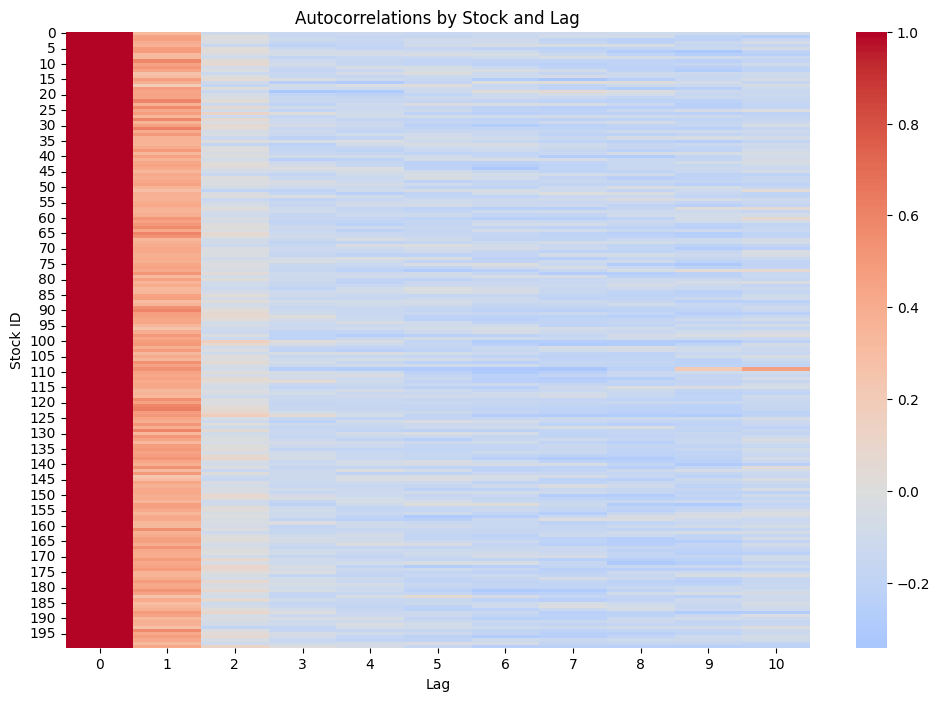

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(autocorrelations_df, cmap='coolwarm', center=0)
plt.title('Autocorrelations by Stock and Lag')
plt.xlabel('Lag')
plt.ylabel('Stock ID')
plt.show()

## 3-B



In [ ]:
compute_distance_cols = ['stock_id', 'date_id', 'price_spread', 'relative_wap',  'liquidity', 'wap' , 'target' ]
compute_distance_df = consensus_record[compute_distance_cols]

In [ ]:
compute_distance_df.head()

,stock_id,date_id,price_spread,relative_wap,liquidity,wap,target
0,0,0,-0.000035,0.545230,0.000916,0.999618,-0.734535
1,0,1,-0.003015,0.541568,0.000882,0.999000,0.328942
2,0,2,0.000000,0.545061,0.000916,0.998962,-0.326709
3,0,3,-0.015914,0.564252,0.001436,0.998919,-3.225099
4,0,4,0.000491,0.552459,0.001047,1.000755,-1.614007


In [ ]:

from itertools import combinations

def calculate_pairwise_distances(dataframe):
    output_data = []

    # Extract unique stock IDs
    unique_stock_ids = dataframe['stock_id'].unique()

    # Generate all possible stock pairs
    possible_stock_pairs = combinations(unique_stock_ids, 2)

    # Loop through each pair
    for stock_x, stock_y in possible_stock_pairs:
        df_stock_x = dataframe[dataframe['stock_id'] == stock_x].set_index('date_id')
        df_stock_y = dataframe[dataframe['stock_id'] == stock_y].set_index('date_id')

        # Merge the data for dates present in both dataframes
        merged_data = df_stock_x.join(df_stock_y, how='inner', lsuffix='_x', rsuffix='_y')

        # Calculate the Euclidean distance
        features_to_consider = ['price_spread', 'relative_wap', 'liquidity', 'wap', 'target']
        distance_values = np.linalg.norm(
            merged_data[[f"{feature}_x" for feature in features_to_consider]].values -
            merged_data[[f"{feature}_y" for feature in features_to_consider]].values,
            axis=1
        )

        # Append results to the output list
        for date_id, distance in zip(merged_data.index, distance_values):
            output_data.append({
                'date_id': date_id,
                'stock_x': stock_x,
                'stock_y': stock_y,
                'euclidean_distance': distance
            })

    return pd.DataFrame(output_data)

# Apply the function to your data
pairwise_distances_df = calculate_pairwise_distances(compute_distance_df)
pairwise_distances_df.head()


,date_id,stock_x,stock_y,euclidean_distance
0,0,0,1,1.879109
1,1,0,1,1.333843
2,2,0,1,0.403944
3,3,0,1,4.854945
4,4,0,1,1.329272


- for the pairs to be similar, the standard deviation of their distance should be minimum and the mean of their distance should also be minimum.
- I have taken the lowest 1% of the stocks with low std deviation and low mean distance as the unusually_similar_pairs of stocks and have printed it in the df below.

In [ ]:
stock_pair_stats = pairwise_distances_df.groupby(['stock_x', 'stock_y'])['euclidean_distance'].agg(['mean', 'std']).reset_index()

# Identify stock pairs with both mean and std in the bottom 1%
low_mean_threshold = stock_pair_stats['mean'].quantile(0.01)
low_std_threshold = stock_pair_stats['std'].quantile(0.01)

unusually_similar_pairs = stock_pair_stats[
    (stock_pair_stats['mean'] <= low_mean_threshold) &
    (stock_pair_stats['std'] <= low_std_threshold)
]

unusually_similar_pairs

,stock_x,stock_y,mean,std
38,0,39,1.636156,1.288915
54,0,55,1.566523,1.315857
104,0,105,1.450497,1.211821
159,0,160,1.365046,1.190131
162,0,163,1.552403,1.326447
...,...,...,...,...
19154,160,195,1.405440,1.180477
19234,163,164,1.555999,1.335221
19245,163,175,1.594544,1.348695
19274,164,169,1.648285,1.292515


## Graph for unusually_paired stocks

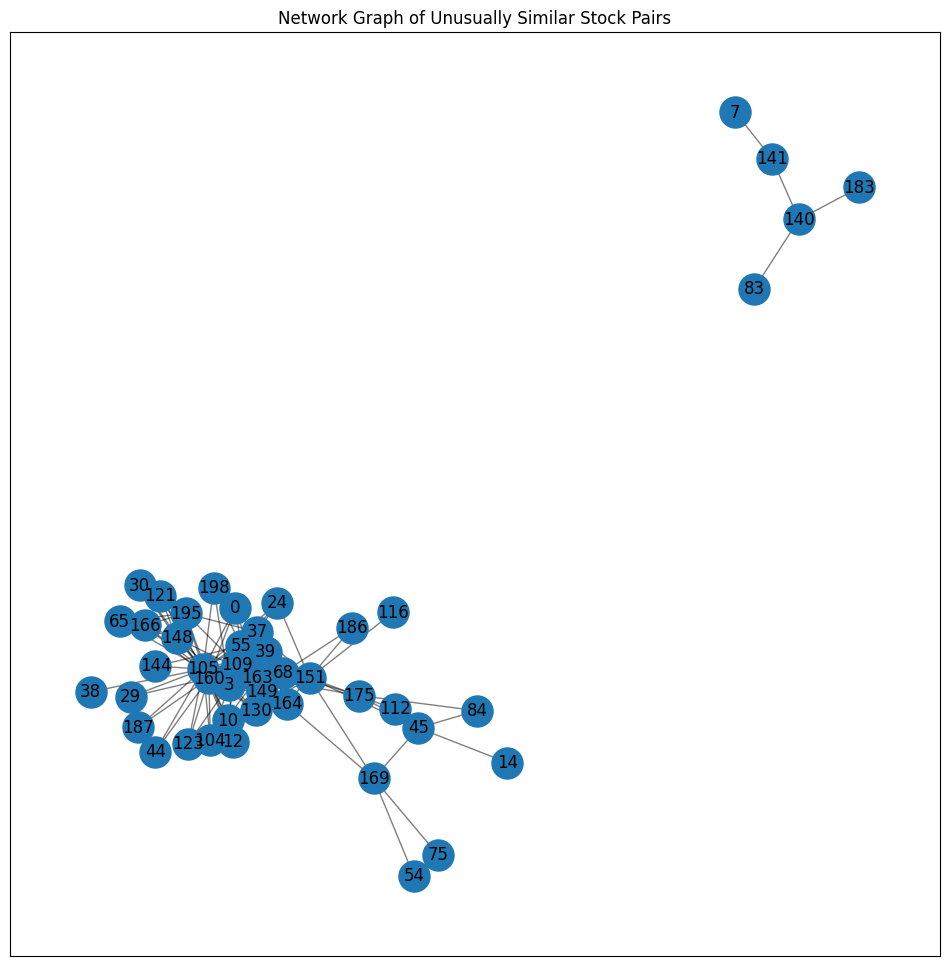

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph
G = nx.Graph()


stocks = set(unusually_similar_pairs['stock_x']).union(set(unusually_similar_pairs['stock_y']))
G.add_nodes_from(stocks)

# Add edges with weight as the mean of the euclidean distance
for _, row in unusually_similar_pairs.iterrows():
    G.add_edge(row['stock_x'], row['stock_y'], weight=row['mean'])

# Draw the network graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12)
plt.title("Network Graph of Unusually Similar Stock Pairs")
plt.show()


## 3-C


In [ ]:
total_consensus = consensus_record.copy()
total_consensus.drop(columns=['seconds_in_bucket', 'date_id'], inplace=True)

# Group by stock_id and compute the mean for each feature
aggregated_data = total_consensus.groupby('stock_id').mean().reset_index()
drops = ['stock_id', 'wap', 'target', 'liquidity']
data_df = aggregated_data[drops]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

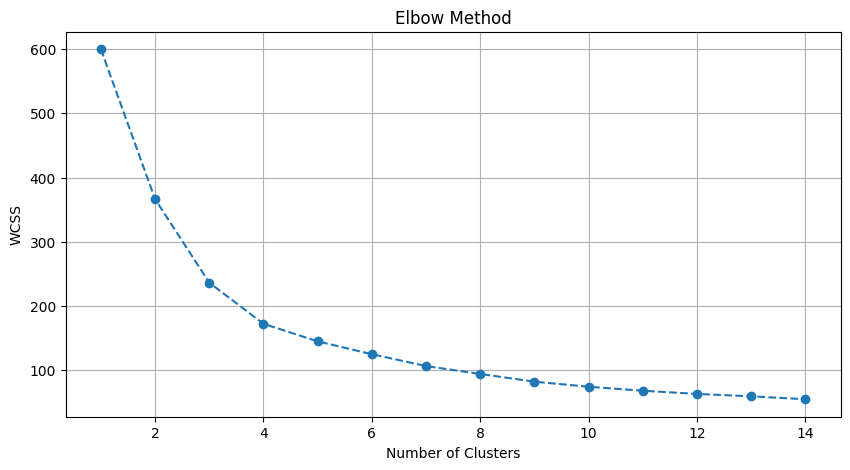

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Standardizing the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_df.drop('stock_id', axis=1))


# Using the elbow method to find the optimal number of clusters
wcss = []  # within-cluster sum of squares
possible_clusters = range(1, 15)

for i in possible_clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plotting the elbow method graph
plt.figure(figsize=(10, 5))
plt.plot(possible_clusters, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


Since the inflection point is coming at 3. I will take K = 3


In [ ]:
kmeans_3 = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters_3 = kmeans_3.fit_predict(scaled_data)
cluster_sizes_3 = pd.Series(clusters_3).value_counts()

cluster_sizes_3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2    106
1     80
0     14
dtype: int64

yes, the colors look coherent and, the clusters are clearly visible

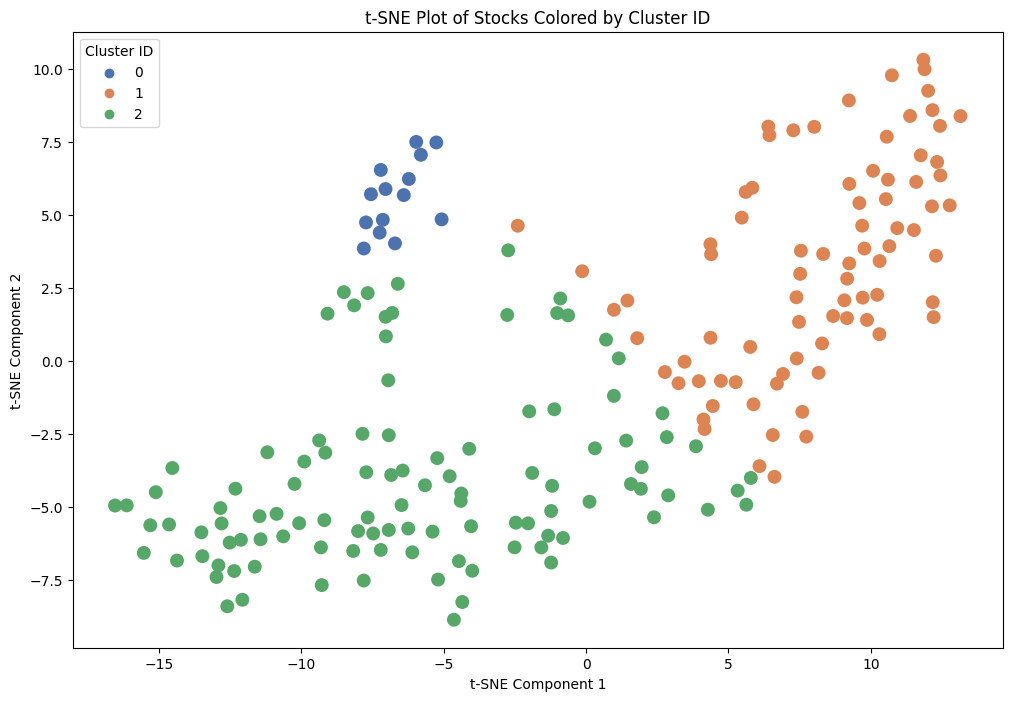

In [ ]:
from sklearn.manifold import TSNE


# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)

# Plotting the t-SNE results with corrected arguments
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=clusters_3, palette="deep", s=100, edgecolor="none")
plt.title('t-SNE Plot of Stocks Colored by Cluster ID')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster ID')
plt.show()


#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts


In [ ]:
closing_values = cleaned_csv.copy()

In [ ]:
# Grouping by stock_id and date_id to get the opening (first) and closing (last) wap for each stock each day
grouped_data = closing_values.sort_values(['stock_id', 'date_id'])
grouped_data = grouped_data.groupby(['stock_id', 'date_id'])


# Calculating the daily return for each stock
daily_return = (grouped_data['wap'].last() - grouped_data['wap'].first())

# Reshaping the data to have date_id as rows and stock_id as columns
daily_return_matrix = daily_return.unstack(level='stock_id')

# Calculating the correlation matrix for the daily returns
correlation_matrix = daily_return_matrix.corr()

daily_return_matrix.head()


stock_id,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
date_id,,,,,,,,,,,,,,,,,,,,,
0,-0.000625,0.000587,0.000649,-0.000576,0.001238,0.002159,0.000038,-0.001109,-0.001471,-0.000558,...,0.001821,0.005131,-0.001417,-0.000305,0.000761,-0.001540,-0.000290,0.000156,-0.000624,NaN
1,-0.000260,0.002029,-0.001137,0.000487,0.003199,0.002233,0.000789,0.002022,0.000288,0.000186,...,-0.000175,-0.000359,0.001253,0.002587,0.004740,0.000211,-0.001627,0.000770,-0.000258,NaN
2,-0.001369,-0.003318,0.000659,-0.000363,-0.002281,-0.000068,-0.000256,0.001274,-0.004372,-0.003552,...,-0.007923,-0.000308,0.001336,-0.000287,0.002116,-0.000288,-0.000478,0.001220,-0.000478,NaN
3,-0.001693,0.002449,0.001424,0.000434,-0.000163,0.001467,-0.001785,0.002296,0.002153,0.001398,...,0.001366,0.000811,0.001620,0.002471,0.003036,0.000414,0.001430,0.000565,0.000540,NaN
4,0.000157,0.001534,0.003033,0.000961,0.004537,-0.001163,-0.000675,0.002988,0.003082,0.000353,...,-0.002033,-0.000343,0.001446,0.002565,0.001974,-0.001528,0.001415,-0.000353,0.000988,NaN


In [ ]:
# Compute the average correlation
average_correlation = (correlation_matrix.sum().sum() - len(correlation_matrix)) / (len(correlation_matrix) * (len(correlation_matrix) - 1))

average_correlation

0.38413379965431615

## Plot 1 : Average daily return across all stocks

-- Consistent Upward/Downward Movement suggests that the majority of stocks are moving in the same direction, thus indicating a market-wide trend.

-- I have used median as the metric here to make sure the outliers do not affect the data

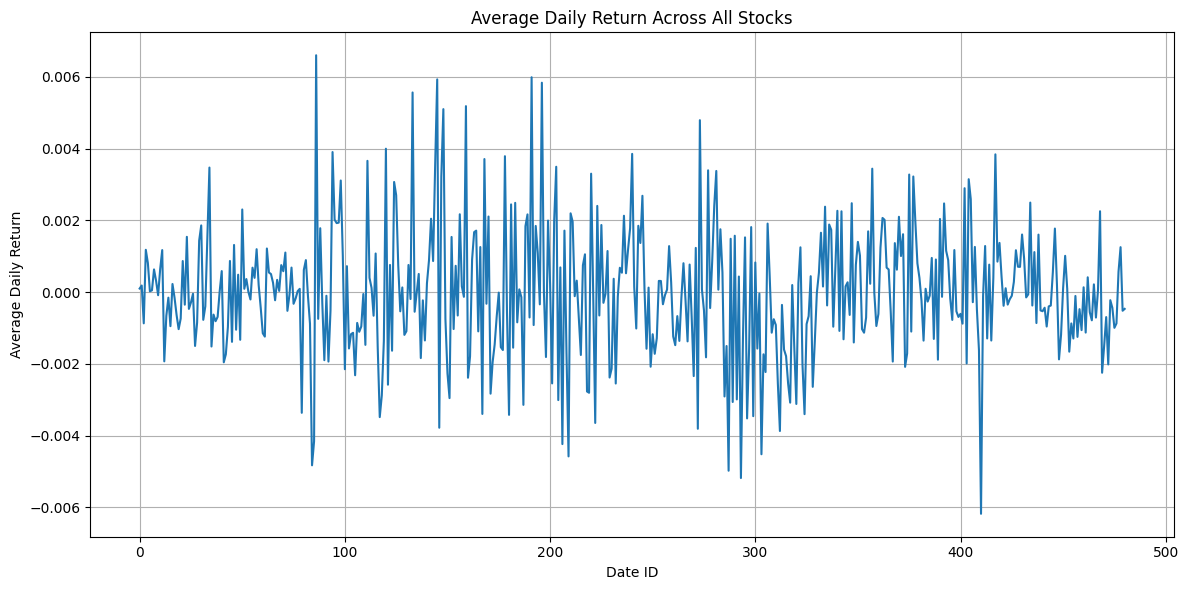

In [ ]:
plt.figure(figsize=(12, 6))
daily_return_matrix.median(axis=1).plot()
plt.title('Average Daily Return Across All Stocks')
plt.xlabel('Date ID')
plt.ylabel('Average Daily Return')
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot 2-Density Plot of Daily Returns for Selected Stocks

- Overlapping densities suggest correlated stock movements.

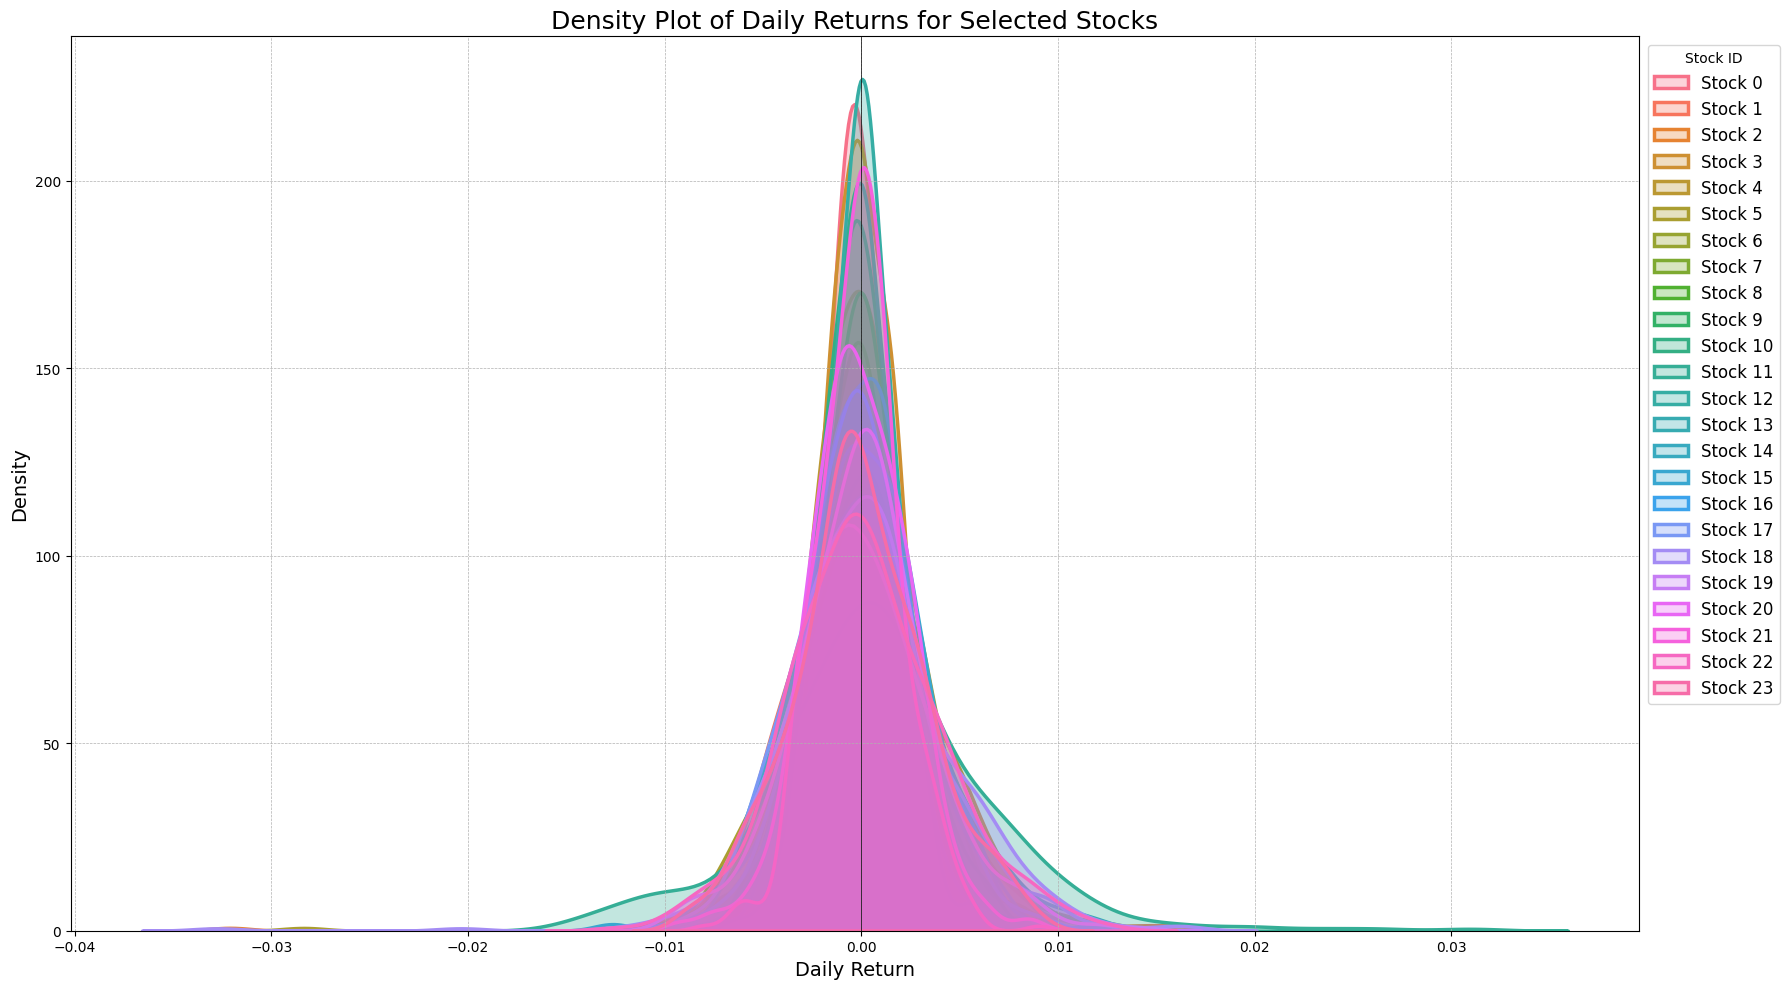

In [ ]:
# Enhanced plotting of the density of daily returns for all stocks

plt.figure(figsize=(18, 10))

# Select a subset of stocks to avoid clutter (for illustration purposes, you can modify this)
selected_columns = daily_return_matrix.columns[:24]

# Use a consistent color palette
palette = sns.color_palette("husl", len(selected_columns))

# Loop through the selected stock's daily returns and plot the density
for idx, column in enumerate(selected_columns):
    sns.kdeplot(daily_return_matrix[column], color=palette[idx], label=f"Stock {column}", lw=2.5, fill=True, alpha=0.3)

plt.title('Density Plot of Daily Returns for Selected Stocks', fontsize=18)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Stock ID', bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()


## Plot 3- Cumulative Average Returns Over Time

-  consistent upward and downward trajectory suggests correlated movements between the stocks.

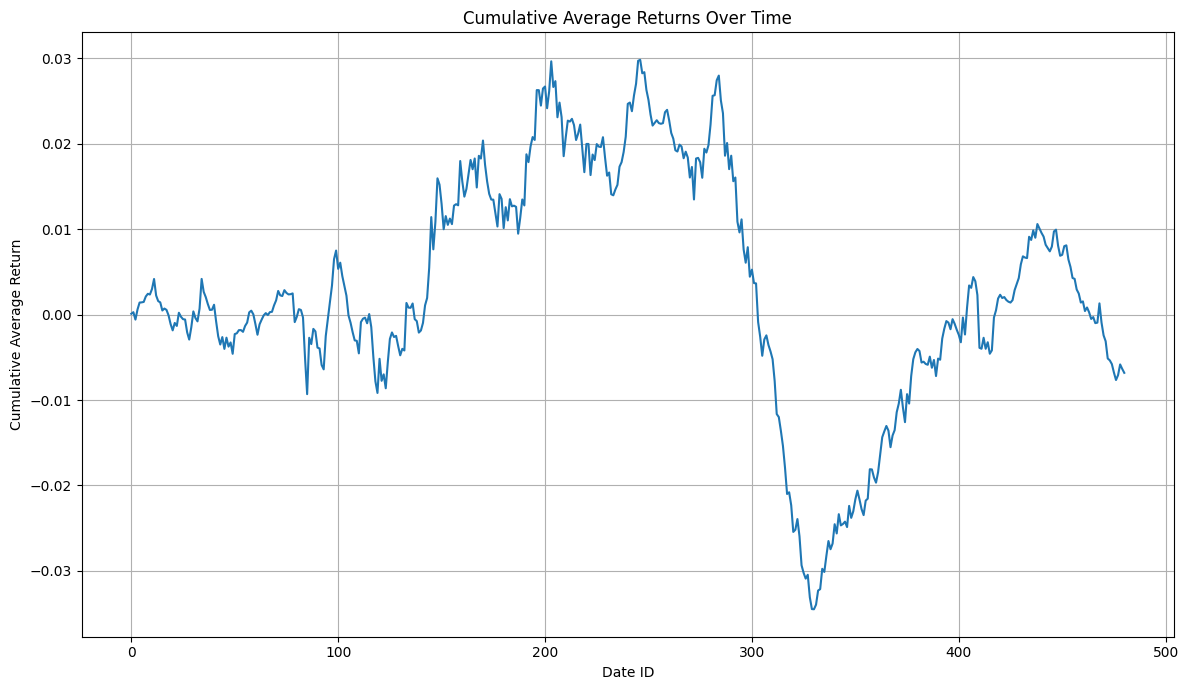

In [ ]:
# Calculate the daily average return across all stocks for each day
daily_average_returns = daily_return_matrix.median(axis=1)

# Compute the cumulative sum of the median returns
cumulative_average_returns = daily_average_returns.cumsum()

# Plot the cumulative average returns
plt.figure(figsize=(12, 7))
cumulative_average_returns.plot()
plt.title('Cumulative Average Returns Over Time')
plt.xlabel('Date ID')
plt.ylabel('Cumulative Average Return')
plt.grid(True)
plt.tight_layout()
plt.show()


## 4-B

- the P-value is coming out to be 0.653. I cannot reject the null hypothesis that the observed correlation between stocks could have arisen by chance.But, the value is small enough to assume that, there is some correlation between the daily returns of different stocks, though it's not statistically significant. Therefore, it's plausible to say that individual stock movements are influenced more by external/unknown factors rather than a market-wide trend.

In [ ]:
# Number of permutations
num_permutations = 1000

# Calculate the observed average correlation
observed_avg_correlation = (correlation_matrix.sum().sum() - len(correlation_matrix)) / (len(correlation_matrix) * (len(correlation_matrix) - 1))

# Initialize an array to store average correlations from permuted data
permuted_avg_correlations = np.zeros(num_permutations)

# Permutation procedure
for i in range(num_permutations):
    # Randomly permute the day index for each stock
    permuted_data = daily_return_matrix.sample(frac=1, replace=False, axis=0).reset_index(drop=True)

    # Compute the correlation matrix for permuted data
    permuted_corr_matrix = permuted_data.corr()

    # Calculate the average correlation for permuted data
    permuted_avg_correlations[i] = (permuted_corr_matrix.sum().sum() - len(permuted_corr_matrix)) / (len(permuted_corr_matrix) * (len(permuted_corr_matrix) - 1))

# Calculate the p-value
p_value = (np.abs(permuted_avg_correlations) >= np.abs(observed_avg_correlation)).mean()

observed_avg_correlation, p_value


(0.38413379965431615, 0.653)

#### Q5: Best prediction model, any approaches, 25 pts

-- I have decided to use LightGBM for the following reasons:
-  its effecinecy and speed
- its support for large datasets as our dataset is really large
- as well as its ability to handle catagorical features (buy-sell flag) and missing values (near and far prices)


In [ ]:
df = cleaned_csv.copy()

x=df.drop(['target'],axis=1)
y=df[['target']]


In [ ]:
def data_preprocessing(x):
    x['imbalance_ratio'] = x['imbalance_size'] / x['matched_size']
    x['bid_ask_volume_diff'] = x['ask_size'] - x['bid_size']
    x['mid_price'] = (x['ask_price'] + x['bid_price']) / 2
    x['bid_plus_ask_sizes'] = x['bid_size'] + x['ask_size']
    if 'time_id' not in x.columns:
        x['time_id']=[0]*x.shape[0]
    x.drop(['far_price','near_price','imbalance_size','matched_size','ask_size','bid_size','row_id','time_id'],axis=1,inplace=True)
    for i in x.columns:
        if x[i].isnull().sum()>0:
            x[i].fillna(x[i].median(),inplace=True)
    return x

In [ ]:
x=data_preprocessing(x)
y.fillna(y.median(),inplace=True)

<ipython-input-35-db987fe21bad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(y.median(),inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.5,random_state=1)



In [ ]:
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from lightgbm import LGBMRegressor

LGB = LGBMRegressor()
LGB.fit(x_train,y_train)
pred_LGB=LGB.predict(x_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 2618946, number of used features: 12
[LightGBM] [Info] Start training from score -0.045785


In [ ]:
from sklearn.model_selection import cross_val_score


neg_mae_scores = cross_val_score(LGB, x, y, cv=5, scoring='neg_mean_absolute_error', verbose=0)

# Convert negative MAE to positive values
mae_scores = -neg_mae_scores


# Compute the average of the MAE scores from the 5 folds
average_mae = mae_scores.mean()

average_mae


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.844180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 12
[LightGBM] [Info] Start training from score -0.039070
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 12
[LightGBM] [Info] Start training from score -0.046592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

6.324699184100457

#### Q6: submit model on Kaggle, 0 pts
Public Score: 5.4251 \
Private Score: 5.4251 \
Kaggle profile link: https://www.kaggle.com/kunalgargmm \
Screenshot(s): \
